# UE Computer Vision | Project : Visual tracking of video objects

February 2022

pierre-henri.conze@imt-atlantique.fr, ronan.fablet@imt-atlantique.fr

aurelien.colin@imt-atlantique.fr, quentin.febvre@imt-atlantique.fr, matteo.zambra@imt-atlantique.fr

---

``Student names: Binh Minh NGUYEN, Minh-Triet VO, Christopher JABEA``

---

## Purpose of the project

Implement the methodology described in one of the two articles and apply it in the context of **visual tracking of video objects** within image sequences. Specifically, the targeted application consists in estimating for the whole sequence the location of a manually defined region of interest in the first image, called **reference image**. Development will be done in `python` programming language and can use functions from librairies such as `openCV`, `scikit-image`, `scikit-learn`, `keras`, `pytorch`... 

In [ ]:
import numpy as np
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
import os

## Data

You have 6 video sequences containing a **variable number of images** (from 26 to 196). You can evaluate your method with these videos and compare it with the approaches implemented by the other groups as well as the baseline provided below. The **training sequences** (`bag`, `bear`, `book`, `camel`, `rhino`, `swan`) are available on Moodle.

A binary mask is associated to each image to locate the object of interest (foreground object). Only one object of interest is targeted ! Except for the reference image, these **groundtruth masks** can only be used for the evaluation of the implemented method. 

**Test sequences** will be provided at the end of the project.

In [ ]:
name = 'sequences-train/swan' # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, 26 # reference image (1) and last image (varies depending on the sequence)

Let us visualize some images with associated groundtruth masks.

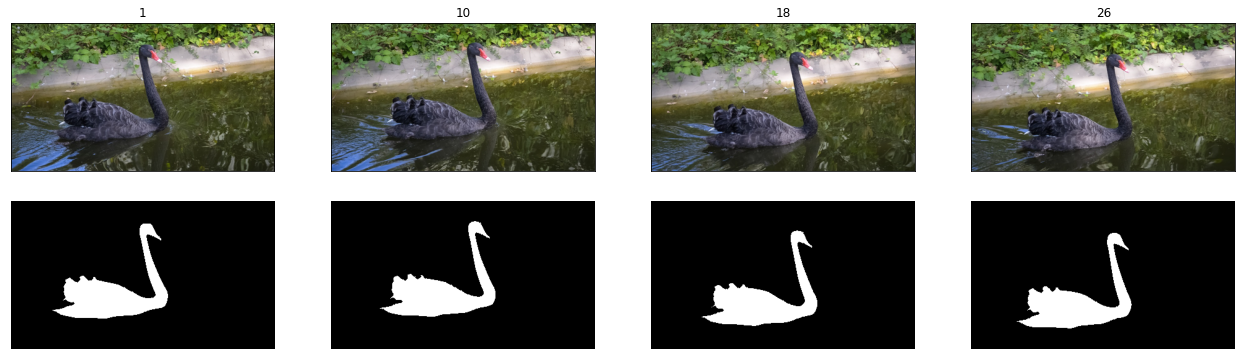

In [ ]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([1,10,18,26]):
    img_current = io.imread(name+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(name+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The `dice_assessment()`, `db_eval_boundary()` and `centroid_assessment()` functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object. 

`dice_assessment()` evaluates the overlap between the two masks while `db_eval_boundary()` quantifies the quality of the estimated contours. Each function returns a score between 0% (poor quality) and 100% (perfect quality).

`centroid_assessment()` comptes the *Euclidean* distance between groundtruth and estimated centroids.

In [ ]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [ ]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(np.bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [ ]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

#  Baseline method

The **baseline** code below shows, as an indication, the implementation of a possible methodology (among others) to meet the project requirements. 

Let us consider a sequence of $N$ RGB images $\{I_{n}\}$ with $n\in \{1,\ldots,N\}$ where $I_{1}$ is the so-called **reference image**. Here, we estimate the long term motion between each image $I_{n}$ with $n \neq 1$ and the reference image $I_{1}$ by means of an optical flow estimator which processes the pairs $\{I_{n},I_{1}\}$ independently.

In this example, an `openCV` implementation of the **Farnebäck's optical flow estimator** (G. Farnebäck, [Two-frame motion estimation based on polynomial expansion](https://link.springer.com/content/pdf/10.1007/3-540-45103-x_50.pdf), Image Analysis, pp. 363–370, 2003) is used.


In [ ]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

Once the optical flow fields have been estimated, the `propagate_mask() `function below can propagate the groundtruth segmentation mask from $I_{1}$ to $I_{n}$.

In [ ]:
def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint8)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(np.int), np.rint(y+flow[x,y,0]).astype(np.int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

In [ ]:
img_begin = io.imread(name+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread(name+'-%0*d.png'%(3,im_begin))

dices, fmeasures, centroid_dist, visu = [], [], [], []
for im in range(im_begin+1,im_end+1):
    # print(im) # debug
    img_current = io.imread(name+'-%0*d.bmp'%(3,im))
    mask_current = io.imread(name+'-%0*d.png'%(3,im))
    flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
    propagation = propagate_mask(flow, img_current, mask_begin)
    io.imsave(name+'-prop-%0*d.png'%(3,im), img_as_ubyte(propagation))
    visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation, color=(1,0,0)))
    io.imsave(name+'-bound-%0*d.png'%(3,im), img_as_ubyte(visu[-1]))
    dices.append(dice_assessment(mask_current, propagation))
    fmeasures.append(db_eval_boundary(mask_current, propagation))
    centroid_dist.append(centroid_assessment(mask_current, propagation))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Inference script

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/IMT 3eme annee/Computer Vision/Project/FlowNetPytorch

/content/drive/MyDrive/IMT 3eme annee/Computer Vision/Project/FlowNetPytorch


In [ ]:
from pathlib import Path
from imageio import imread, imwrite
import numpy as np
from glob import glob
import time
from scipy.interpolate import interp2d
import os
import cv2
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import distutils.dir_util
from skimage.measure import regionprops

### Helper functions

In [ ]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100


def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(np.bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap


def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))


def propagate_mask(flow, img_current, mask_begin):
    new_mask = np.zeros(shape=img_current.shape[:2], dtype=np.uint32)
    for x in range(img_current.shape[0]):
        for y in range(img_current.shape[1]):
            x_, y_ = np.rint(x+flow[x,y,1]).astype(int), np.rint(y+flow[x,y,0]).astype(int)
            if (x_>=0) and (x_<img_current.shape[0]) and (y_>=0) and (y_<img_current.shape[1]):
                if mask_begin[x_,y_] > 0:
                    new_mask[x,y] = 255
    return new_mask

def concatenation(unary_flow, to_ref_flow):
    flow = np.zeros((unary_flow.shape[0],unary_flow.shape[1],2), dtype=np.float32)
    x0 = np.arange(0, unary_flow.shape[0])
    y0 = np.arange(0, unary_flow.shape[1])
    xx, yy = np.meshgrid(x0, y0)
    z = to_ref_flow[xx,yy,1]
    fx = interp2d(x0,y0,z,kind='quintic')
    z = to_ref_flow[xx,yy,0]
    fy = interp2d(x0,y0,z,kind='quintic')
    for x in range(unary_flow.shape[0]):
        for y in range(unary_flow.shape[1]):
            flow_x = fx(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow_y = fy(x+unary_flow[x,y,1], y+unary_flow[x,y,0])
            flow[x,y,1] = unary_flow[x,y,1] + flow_x
            flow[x,y,0] = unary_flow[x,y,0] + flow_y
    return flow

## Flownet

### Download required packages

In [ ]:
!pip install -r requirements.txt

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


### Flownet implementation

In [ ]:
img_path = 'sequences_test'
flow_path = 'sequences_test/flow'
name = 'octopus'
preprocess = '_detail_enhance'

flow_files = sorted(glob(os.path.join(flow_path,name + '*.npy')))
img_ext = 'bmp'
mask_ext = 'png'
img_files = sorted(glob(os.path.join(img_path,name + '*.' + img_ext)))
mask_files = sorted(glob(os.path.join(img_path,name + '*.' + mask_ext)))
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess

im_begin = 1
# im_end = len(img_files)
im_end = 26

In [ ]:
start = time.time()
!python3 run_inference.py $img_path pretrained_models/flownets_EPE1.951.pth.tar --seq_name $name --img_exts bmp --bidirectional -v raw --div-flow 15

=> will save raw output
=> fetching img pairs in 'sequences_test'
=> will save everything to sequences_test/flow
25 pairs found
=> using pre-trained model 'flownets'
'flownets' does not have default div_flow.
100% 25/25 [00:05<00:00,  4.48it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


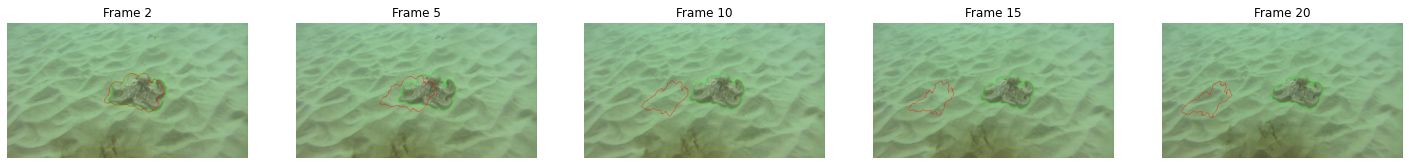

The process finishes in 7.18 minutes


In [ ]:
img_begin = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im_begin))).astype(np.float32)/255.
mask_begin = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im_begin)))
seq_dices_FN, seq_fmeasures_FN, centroid_dist_FN = [], [], []
flow_FN_final = np.zeros((img_begin.shape[0], img_begin.shape[1], 2))
start = time.time()
## Plot masks in a row for presentation
plt.figure(figsize=(25,5))
subplot_step = 5
subplot_list = [2,subplot_step,subplot_step*2,subplot_step*3,subplot_step*4]

for im in range(im_begin+1,im_end+1):
  # print(im)
  img_current = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im))).astype(np.float32)/255.
  mask_current = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im)))
  img_precendent = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im-1))).astype(np.float32)/255.

  flow_FN = np.load(os.path.join(flow_path,name+'-%0*d'%(3,im)+'flow.npy'))
  flow_FN_final = concatenation(flow_FN, flow_FN_final)

  propagation_FN = propagate_mask(flow_FN_final, img_current, mask_begin) 
  boundaries_FN = mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation_FN, color=(1,0,0))
  seq_dices_FN.append(dice_assessment(mask_current, propagation_FN))
  seq_fmeasures_FN.append(db_eval_boundary(mask_current, propagation_FN))
  centroid_dist_FN.append(centroid_assessment(mask_current, propagation_FN))

  ## Plot masks in a row for presentation
  if im in subplot_list:
    plt.subplot(1,5,im//subplot_step+1)
    plt.axis('off')
    plt.title("Frame {}".format(im))
    plt.imshow(boundaries_FN)
plt.show()

end = time.time()
print("The process finishes in {:.2f} minutes".format((end-start)/60))
np.save(dices_filename, seq_dices_FN)
np.save(fmeasures_filename, seq_fmeasures_FN)
np.save(centroid_dist_filename, centroid_dist_FN)

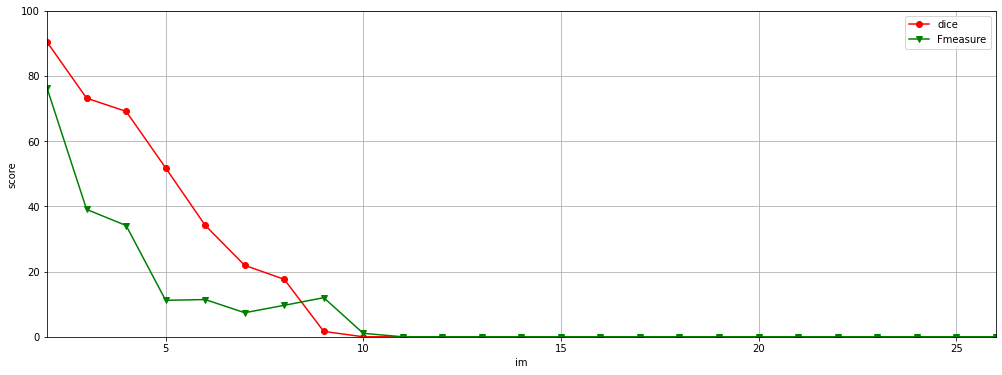

In [ ]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
plt.plot(x,seq_dices_FN,marker='o',color='r')
plt.plot(x,seq_fmeasures_FN,marker='v',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(['dice', 'Fmeasure'])
plt.savefig('eval.png')
plt.show()

Time measurement:

1. No preprocessing: 2.28 minutes
2. Gaussian blurring: 2.23 minutes
3. Edge preserving: 2.17 minutes
4. Detail enhancement: 2.16 minutes
5. Pencil sketch filter: 2.23 minutes


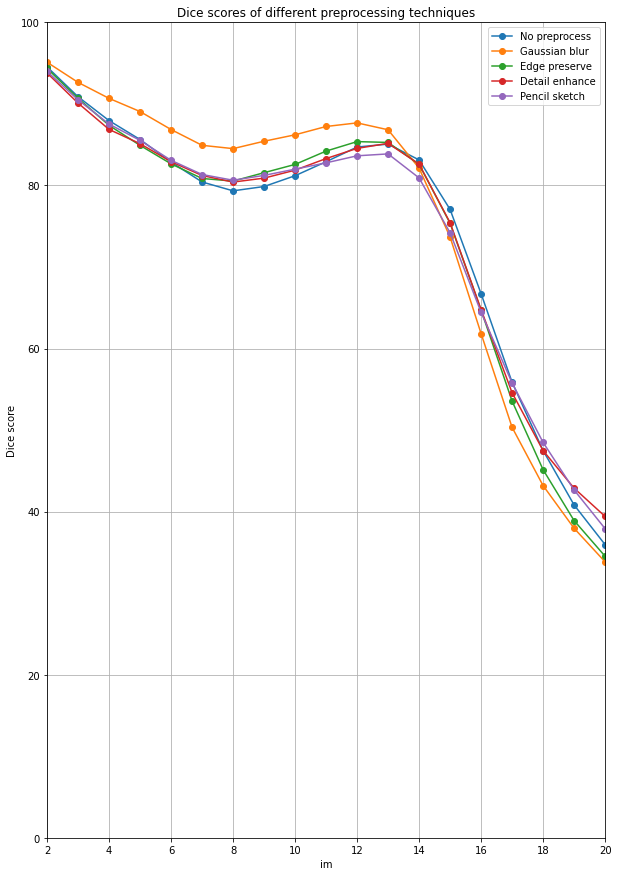

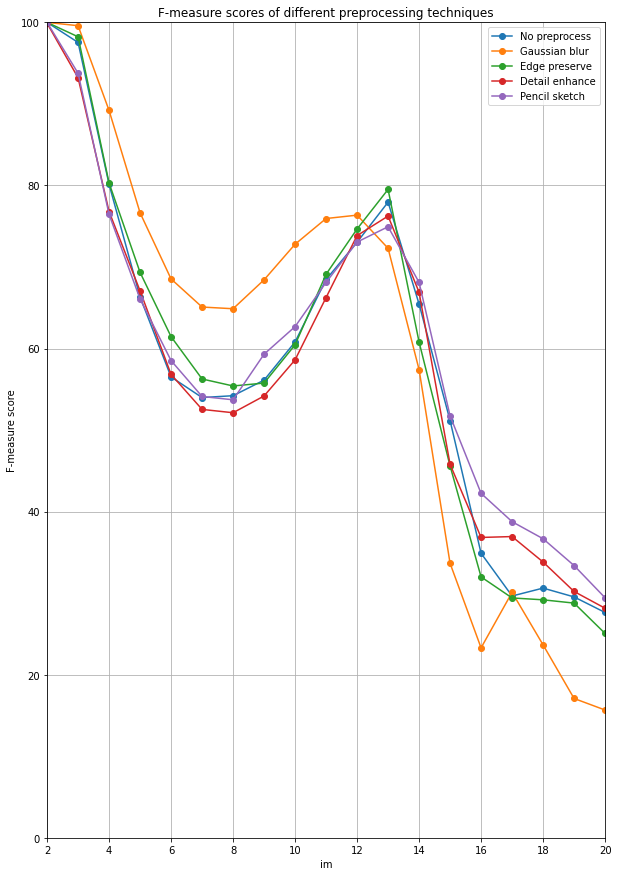

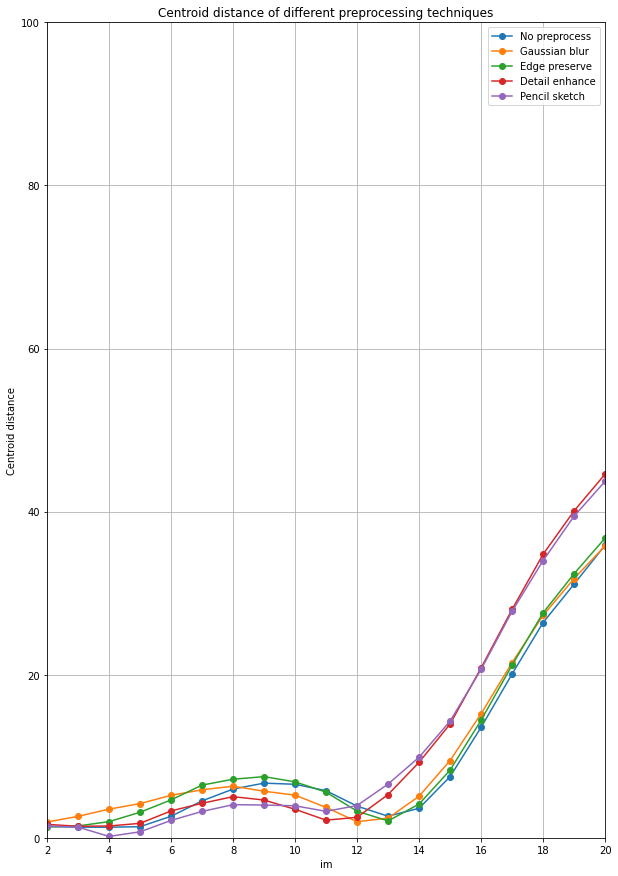

In [ ]:
dice_swan_none = np.load('dice_swan_none.npy')
dice_swan_gauss5x5 = np.load('dice_swan_gauss5x5.npy')
dice_swan_edge_preserve = np.load('dice_swan_edge_preserve.npy')
dice_swan_detail_enhance = np.load('dice_swan_detail_enhance.npy')
dice_swan_pencil_sketch = np.load('dice_swan_pencil_sketch.npy')

fmeasure_swan_none = np.load('fmeasure_swan_none.npy')
fmeasure_swan_gauss5x5 = np.load('fmeasure_swan_gauss5x5.npy')
fmeasure_swan_edge_preserve = np.load('fmeasure_swan_edge_preserve.npy')
fmeasure_swan_detail_enhance = np.load('fmeasure_swan_detail_enhance.npy')
fmeasure_swan_pencil_sketch = np.load('fmeasure_swan_pencil_sketch.npy')

centroid_dist_swan_none = np.load('centroid_dist_swan_none.npy')
centroid_dist_swan_gauss5x5 = np.load('centroid_dist_swan_gauss5x5.npy')
centroid_dist_swan_edge_preserve = np.load('centroid_dist_swan_edge_preserve.npy')
centroid_dist_swan_detail_enhance = np.load('centroid_dist_swan_detail_enhance.npy')
centroid_dist_swan_pencil_sketch = np.load('centroid_dist_swan_pencil_sketch.npy')

x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 15))
plt.plot(x,dice_swan_none,marker='o')
plt.plot(x,dice_swan_gauss5x5,marker='o')
plt.plot(x,dice_swan_edge_preserve,marker='o')
plt.plot(x,dice_swan_detail_enhance,marker='o')
plt.plot(x,dice_swan_pencil_sketch,marker='o')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('Dice score')
plt.xlabel("im")
plt.title('Dice scores of different preprocessing techniques')
plt.grid()
plt.legend(['No preprocess', 'Gaussian blur', 'Edge preserve', 'Detail enhance', 'Pencil sketch'])
plt.savefig('Dices_5_analysis.png')
plt.show()

plt.figure(figsize=(10, 15))
plt.plot(x,fmeasure_swan_none,marker='o')
plt.plot(x,fmeasure_swan_gauss5x5,marker='o')
plt.plot(x,fmeasure_swan_edge_preserve,marker='o')
plt.plot(x,fmeasure_swan_detail_enhance,marker='o')
plt.plot(x,fmeasure_swan_pencil_sketch,marker='o')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('F-measure score')
plt.xlabel("im")
plt.title('F-measure scores of different preprocessing techniques')
plt.grid()
plt.legend(['No preprocess', 'Gaussian blur', 'Edge preserve', 'Detail enhance', 'Pencil sketch'])
plt.savefig('Fmeasure_5_analysis.png')
plt.show()

plt.figure(figsize=(10, 15))
plt.plot(x,centroid_dist_swan_none,marker='o')
plt.plot(x,centroid_dist_swan_gauss5x5,marker='o')
plt.plot(x,centroid_dist_swan_edge_preserve,marker='o')
plt.plot(x,centroid_dist_swan_detail_enhance,marker='o')
plt.plot(x,centroid_dist_swan_pencil_sketch,marker='o')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('Centroid distance')
plt.xlabel("im")
plt.title('Centroid distance of different preprocessing techniques')
plt.grid()
plt.legend(['No preprocess', 'Gaussian blur', 'Edge preserve', 'Detail enhance', 'Pencil sketch'])
plt.savefig('Centroid_dist_5_analysis.png')
plt.show()

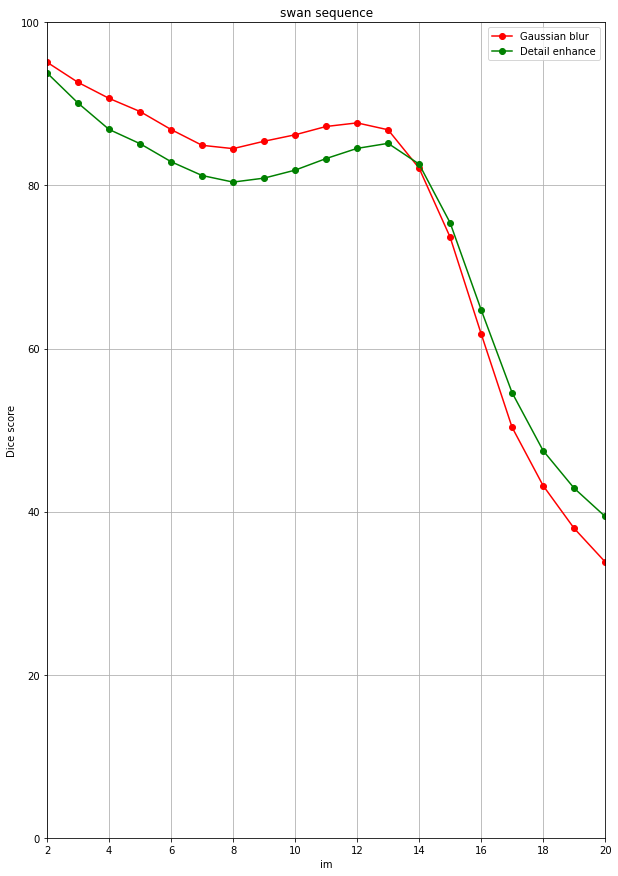

In [ ]:
name = 'swan'
preprocess = '_gauss'
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice1 = np.load(dices_filename+'.npy')
fmeasure1 = np.load(fmeasures_filename+'.npy')
centroid_dist1 = np.load(centroid_dist_filename+'.npy')

preprocess = '_detail_enhance'
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice2 = np.load(dices_filename+'.npy')
fmeasure2 = np.load(fmeasures_filename+'.npy')
centroid_dist2 = np.load(centroid_dist_filename+'.npy')

x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 15))
plt.plot(x,dice1,marker='o',color='r')
plt.plot(x,dice2,marker='o',color='g')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('{} sequence'.format(name))
plt.ylabel('Dice score')
plt.xlabel("im")
plt.grid()
plt.legend(['Gaussian blur', 'Detail enhance'])
# plt.savefig('eval.png')
plt.show()

## Classical

In [ ]:
def farneback(im1, im2):
    return cv2.calcOpticalFlowFarneback(im1, im2, None, pyr_scale=0.5, levels=3, winsize=7, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) # None

def deepflow(im1, im2):
  dtvl1=cv2.optflow.createOptFlow_DeepFlow()
  flowDTVL1=dtvl1.calc(im1,im2,None)
  return flowDTVL1

In [ ]:
img_path = 'sequences_test'
name = 'octopus' # name of the sequence : bag, bear, book, camel, rhino, swan
im_begin, im_end = 1, 26 # reference image (1) and last image (varies depending on the sequence)
method = "deepflow"
strategy = "direct"
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
sigma_s = 60
sigma_r = 0.3

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


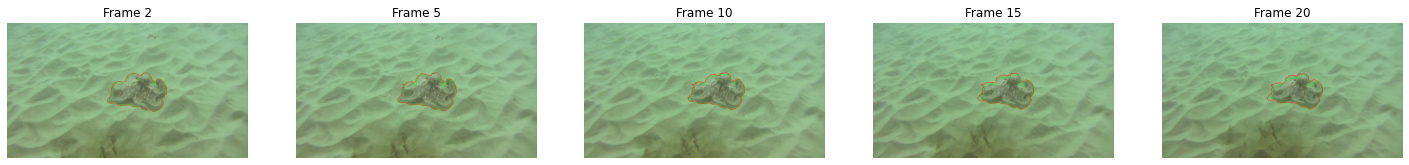

The process finished in 1.72 minutes


In [ ]:
start = time.time()
img_begin = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im_begin)))
mask_begin = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im_begin)))

## Plot masks in a row for presentation
plt.figure(figsize=(25,5))
subplot_step = 5
subplot_list = [2,subplot_step,subplot_step*2,subplot_step*3,subplot_step*4]

seq_dices_FN, seq_fmeasures_FN, centroid_dist_FN, visu = [], [], [], []
if strategy == "direct":
  for im in range(im_begin+1,im_end+1):
      print(im) # debug
      img_current = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im)))
      mask_current = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im)))

      if method == "deepflow":
        flow = deepflow(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
      else:
        flow = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_begin)))
      propagation_FN = propagate_mask(flow, img_current, mask_begin)
      boundaries_FN = mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation_FN, color=(1,0,0))
      seq_dices_FN.append(dice_assessment(mask_current, propagation_FN))
      seq_fmeasures_FN.append(db_eval_boundary(mask_current, propagation_FN))
      centroid_dist_FN.append(centroid_assessment(mask_current, propagation_FN))

      # For each frame visualization
      # plt.figure(figsize=(8, 8))
      # plt.axis('off')
      # plt.imshow(boundaries_FN)
      # plt.show()

      # For multi-frame to paste onto the presentation
      ## Plot masks in a row for presentation
      if im in subplot_list:
        plt.subplot(1,5,im//subplot_step+1)
        plt.axis('off')
        plt.title("Frame {}".format(im))
        plt.imshow(boundaries_FN)
  plt.show()

else:
  flow_FN_final = np.zeros((img_begin.shape[0], img_begin.shape[1], 2))

  for im in range(im_begin+1,im_end+1):
    print(im)
    img_current = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im)))
    mask_current = io.imread(os.path.join(img_path,name+'-%0*d.png'%(3,im)))
    img_precendent = io.imread(os.path.join(img_path,name+'-%0*d.bmp'%(3,im-1)))

    if method == "deepflow":
        flowFN = deepflow(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_precendent)))
    else:
        flowFN = farneback(img_as_ubyte(rgb2gray(img_current)), img_as_ubyte(rgb2gray(img_precendent)))

    flow_FN_final = concatenation(flowFN, flow_FN_final)

    propagation_FN = propagate_mask(flow_FN_final, img_current, mask_begin) 
    boundaries_FN = mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), propagation_FN, color=(1,0,0))
    seq_dices_FN.append(dice_assessment(mask_current, propagation_FN))
    seq_fmeasures_FN.append(db_eval_boundary(mask_current, propagation_FN))
    centroid_dist_FN.append(centroid_assessment(mask_current, propagation_FN))

    # For each frame visualization
    # plt.figure(figsize=(8, 8))
    # plt.axis('off')
    # plt.imshow(boundaries_FN)
    # plt.show()

    # For multi-frame to paste onto the presentation
    ## Plot masks in a row for presentation
    if im in subplot_list:
      plt.subplot(1,5,im//subplot_step+1)
      plt.axis('off')
      plt.title("Frame {}".format(im))
      plt.imshow(boundaries_FN)
  plt.show()
  
end = time.time()
print("The process finished in {:.2f} minutes".format((end-start)/60))
np.save(dices_filename, seq_dices_FN)
np.save(fmeasures_filename, seq_fmeasures_FN)
np.save(centroid_dist_filename, centroid_dist_FN)


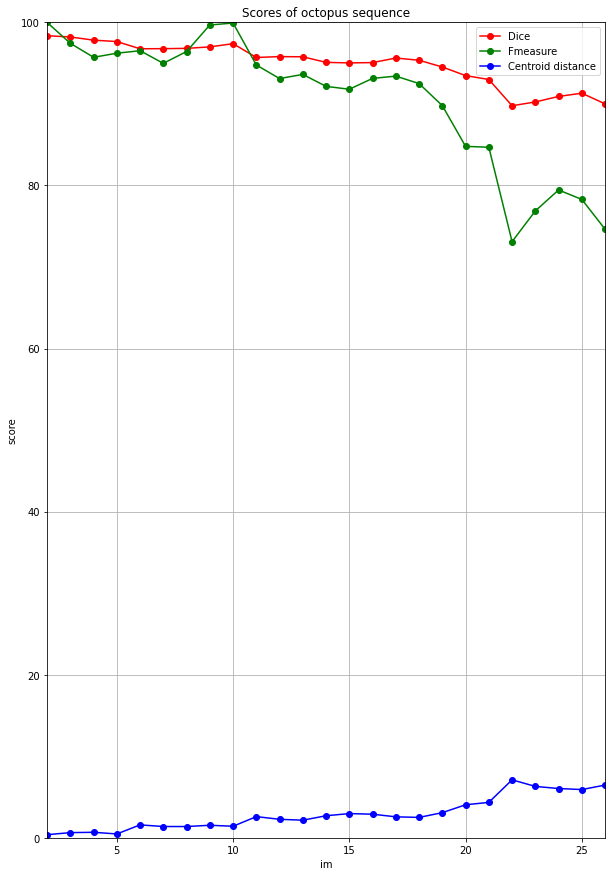

In [ ]:
im_begin,im_end = 1, 26
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 15))
name = 'octopus'
dices_file = 'team1-'+name+'-dice'
fmeasures_file = 'team1-'+name+'-fmeasure'
centroids_file = 'team1-'+name+'-centroid'
seq_dices = np.load('challenge_results/'+dices_file+'.npy')
seq_fmeasures = np.load('challenge_results/'+fmeasures_file+'.npy')
seq_centroids = np.load('challenge_results/'+centroids_file+'.npy')
plt.plot(x,seq_dices,marker='o',color='r')
plt.plot(x,seq_fmeasures,marker='o',color='g')
plt.plot(x,seq_centroids,marker='o',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.title('Scores of {} sequence'.format(name))
plt.grid()
plt.legend(['Dice', 'Fmeasure','Centroid distance'])
plt.savefig('eval.png')
plt.show()

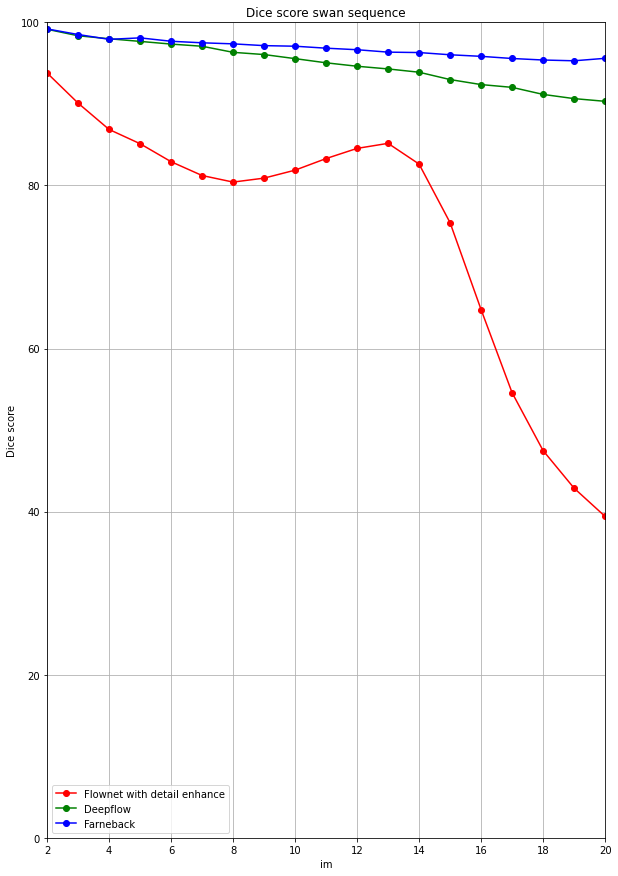

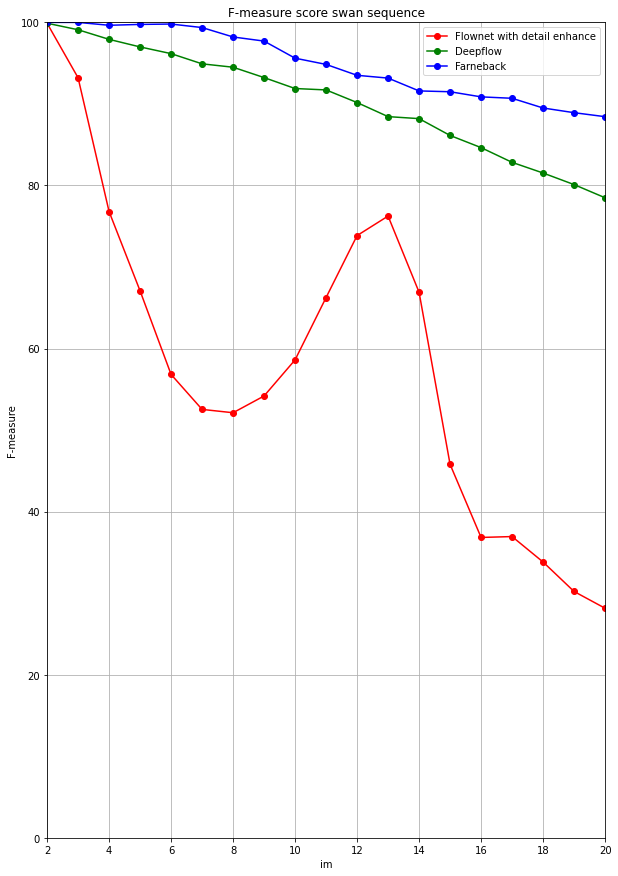

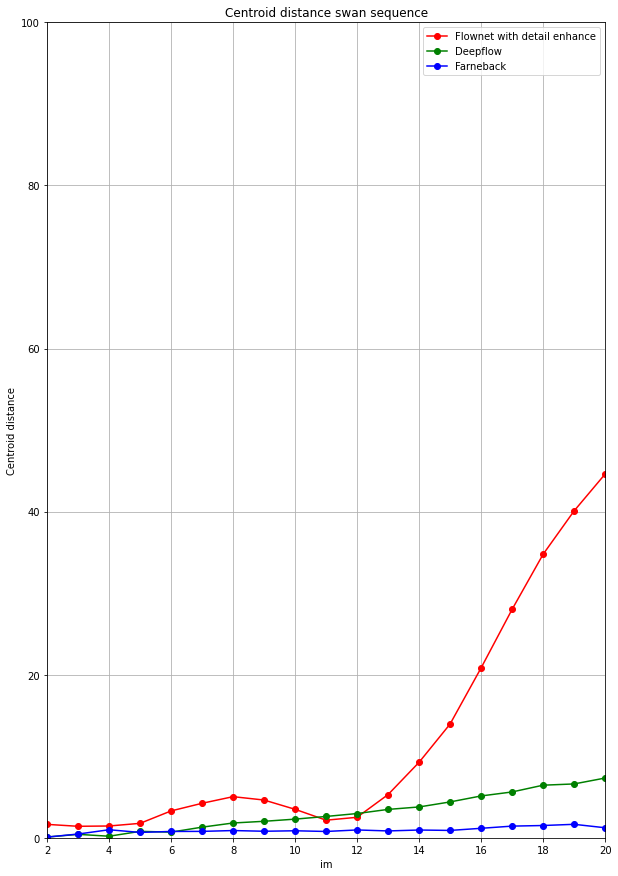

In [ ]:
name = 'swan'
preprocess = '_detail_enhance'
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice1 = np.load(dices_filename+'.npy')
fmeasure1 = np.load(fmeasures_filename+'.npy')
centroid_dist1 = np.load(centroid_dist_filename+'.npy')

method = 'deepflow'
strategy = 'sequential'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice2 = np.load(dices_filename+'.npy')
fmeasure2 = np.load(fmeasures_filename+'.npy')
centroid_dist2 = np.load(centroid_dist_filename+'.npy')

method = 'farneback'
strategy = 'sequential'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice3 = np.load(dices_filename+'.npy')
fmeasure3 = np.load(fmeasures_filename+'.npy')
centroid_dist3 = np.load(centroid_dist_filename+'.npy')

x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 15))
plt.plot(x,dice1,marker='o',color='r')
plt.plot(x,dice2,marker='o',color='g')
plt.plot(x,dice3,marker='o',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('Dice score {} sequence'.format(name))
plt.ylabel('Dice score')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet with detail enhance', 'Deepflow', 'Farneback'])
# plt.savefig('eval.png')

plt.figure(figsize=(10, 15))
plt.plot(x,fmeasure1,marker='o',color='r')
plt.plot(x,fmeasure2,marker='o',color='g')
plt.plot(x,fmeasure3,marker='o',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('F-measure score {} sequence'.format(name))
plt.ylabel('F-measure')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet with detail enhance', 'Deepflow', 'Farneback'])

plt.figure(figsize=(10, 15))
plt.plot(x,centroid_dist1,marker='o',color='r')
plt.plot(x,centroid_dist2,marker='o',color='g')
plt.plot(x,centroid_dist3,marker='o',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('Centroid distance {} sequence'.format(name))
plt.ylabel('Centroid distance')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet with detail enhance', 'Deepflow', 'Farneback'])
plt.show()

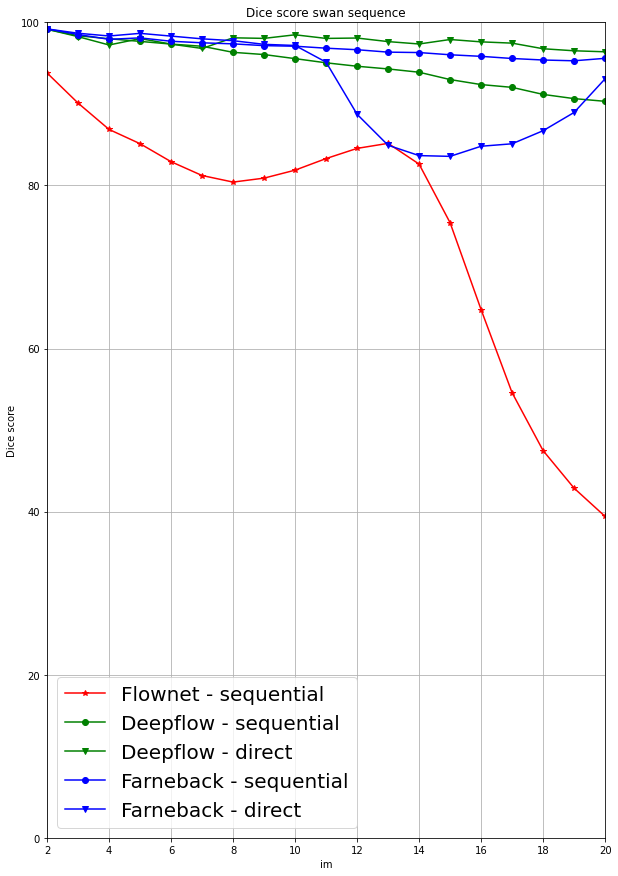

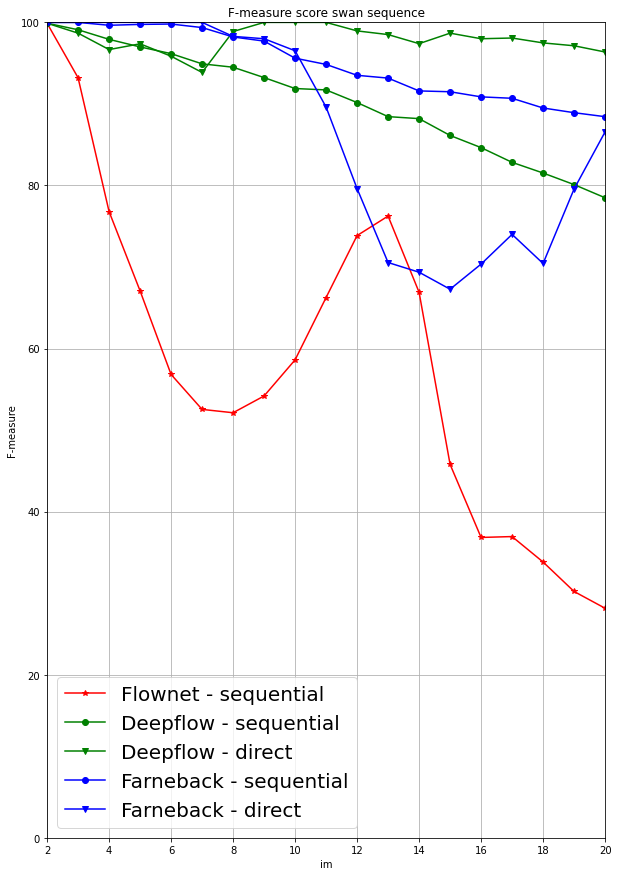

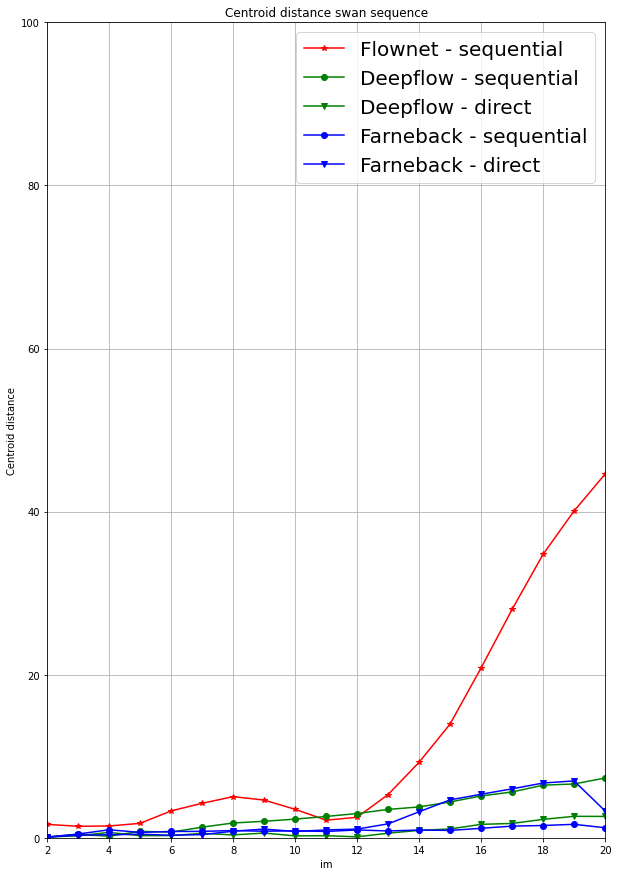

In [ ]:
name = 'swan'
preprocess = '_detail_enhance'
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice1 = np.load(dices_filename+'.npy')
fmeasure1 = np.load(fmeasures_filename+'.npy')
centroid_dist1 = np.load(centroid_dist_filename+'.npy')

method = 'deepflow'
strategy = 'sequential'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice2 = np.load(dices_filename+'.npy')
fmeasure2 = np.load(fmeasures_filename+'.npy')
centroid_dist2 = np.load(centroid_dist_filename+'.npy')

method = 'deepflow'
strategy = 'direct'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice2_ = np.load(dices_filename+'.npy')
fmeasure2_ = np.load(fmeasures_filename+'.npy')
centroid_dist2_ = np.load(centroid_dist_filename+'.npy')

method = 'farneback'
strategy = 'sequential'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice3 = np.load(dices_filename+'.npy')
fmeasure3 = np.load(fmeasures_filename+'.npy')
centroid_dist3 = np.load(centroid_dist_filename+'.npy')

method = 'farneback'
strategy = 'direct'
preprocess = '_'+method+'_'+strategy
dices_filename = 'dice_'+name+preprocess
fmeasures_filename = 'fmeasure_'+name+preprocess
centroid_dist_filename = 'centroid_dist_'+name+preprocess
dice3_ = np.load(dices_filename+'.npy')
fmeasure3_ = np.load(fmeasures_filename+'.npy')
centroid_dist3_ = np.load(centroid_dist_filename+'.npy')

x = range(im_begin+1,im_end+1)
plt.figure(figsize=(10, 15))
plt.plot(x,dice1,marker='*',color='r')
plt.plot(x,dice2,marker='o',color='g')
plt.plot(x,dice2_,marker='v',color='g')
plt.plot(x,dice3,marker='o',color='b')
plt.plot(x,dice3_,marker='v',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('Dice score {} sequence'.format(name))
plt.ylabel('Dice score')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet - sequential', 'Deepflow - sequential', 'Deepflow - direct', 'Farneback - sequential', 'Farneback - direct'], prop={'size':20})
# plt.savefig('eval.png')

plt.figure(figsize=(10, 15))
plt.plot(x,fmeasure1,marker='*',color='r')
plt.plot(x,fmeasure2,marker='o',color='g')
plt.plot(x,fmeasure2_,marker='v',color='g')
plt.plot(x,fmeasure3,marker='o',color='b')
plt.plot(x,fmeasure3_,marker='v',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('F-measure score {} sequence'.format(name))
plt.ylabel('F-measure')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet - sequential', 'Deepflow - sequential', 'Deepflow - direct', 'Farneback - sequential', 'Farneback - direct'], prop={'size':20})

plt.figure(figsize=(10, 15))
plt.plot(x,centroid_dist1,marker='*',color='r')
plt.plot(x,centroid_dist2,marker='o',color='g')
plt.plot(x,centroid_dist2_,marker='v',color='g')
plt.plot(x,centroid_dist3,marker='o',color='b')
plt.plot(x,centroid_dist3_,marker='v',color='b')
plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.title('Centroid distance {} sequence'.format(name))
plt.ylabel('Centroid distance')
plt.xlabel("im")
plt.grid()
plt.legend(['Flownet - sequential', 'Deepflow - sequential', 'Deepflow - direct', 'Farneback - sequential', 'Farneback - direct'], prop={'size':20})
plt.show()